# Scatter Ptychography, use PR and PnP
### Qian Huang
### 07/07/2022

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.measure import block_reduce
from scipy import ndimage

import torch
import torch.nn as nn
import torch.nn.functional as F

import random

_seed = 19971017

random.seed(_seed)
np.random.seed(_seed % 2**32)
torch.manual_seed(_seed)

device='cuda' ## set to 'cpu' if cuda is unavailable
target_name = 'usaf' # usaf, a, osc, or uoa

In [4]:
def pad_to_size(img, size):
    h, w = img.shape
    assert h <= size and w <= size
    left = (size - w)//2
    top = (size - h) //2
    return np.pad(img, ((top, size-h-top), (left, size-w-left)))

def crop_to_size(img, size, offset=0):
    h, w = img.shape
    assert h >= size and w >= size
    left = (w - size)//2+offset 
    top = (h - size)//2+offset
    return img[top:top+size, left:left+size]

def show_stats(complex_img):
    plt.imshow(np.abs(complex_img), cmap='gray')
    plt.title('Amplitude')
    plt.show()
    print_stat(np.abs(complex_img),'Amplitude')
    plt.imshow(np.angle(complex_img), cmap='gray')
    plt.title('Phase')
    plt.show()
    print_stat(np.angle(complex_img),'Phase')

## propagation models

def ASD(f, d, lam, p):
    # INPUT
    ## f: input field
    ## d: distance in m
    ## lam: wavelength in m
    ## p: pixel pitch size in m
    # OUTPUT
    ## g: output field
    pad = int((d*lam/p**2))//2*2+2 if d > 0 else 0
    inF = np.pad(f,((pad, pad), (pad, pad)))
    m, n = inF.shape
    urange = np.linspace(-m/(2*p*m), (m-1)/(2*p*m), m)
    vrange = np.linspace(-n/(2*p*n), (n-1)/(2*p*n), n)
    v, u = np.meshgrid(vrange,urange)
    h = np.exp(1j*2*np.pi*d*np.sqrt((1/lam)**2 - u**2 - v**2))
    g = np.fft.ifft2(np.fft.fftshift(h) * np.fft.fft2(inF))
    return g

def rescale(img, scale):
    return cv2.resize(img,(0,0),fx=scale,fy=scale,interpolation=cv2.INTER_CUBIC)

## MASM
def MASD(f, d=(104.5*25.4)*1e-3, lam=0.532e-6, p=10e-6, x=4e-3):
    # INPUT
    ## f: input field
    ## d: distance in m, positive
    ## lam: wavelength in m
    ## p: pixel pitch size in m
    ## x: object size in m
    # OUTPUT
    ## g: output field
    ## p_out: output field pixel pitch
    g = f
    p_out = p
    h_prev = 0
    while 2*(2*p_out)*x/lam*(p_out/p) < d:
        h = 2*(2*p_out)*x/lam*(p_out/p)
        g = ASD(g, h-h_prev, lam, p_out)
        g = rescale(np.real(g),0.5)+1j*rescale(np.imag(g),0.5)
        h_prev = h
        p_out = 2*p_out
    g = ASD(g, d-h_prev, lam, p_out)
    return g

## MASM
def MASD2(f, d=(104.5*25.4+50.)*1e-3, lam=0.532e-6, p=10e-6, x=4e-3):
    # INPUT
    ## f: input field
    ## d: distance in m, positive
    ## lam: wavelength in m
    ## p: pixel pitch size in m
    ## x: object size in m
    # OUTPUT
    ## g: output field
    ## p_out: output field pixel pitch
    g = f
    p_out = p
    h_prev = 0
    while 2*(2*p_out)*x/lam*(p_out/p) < d:
        h = 2*(2*p_out)*x/lam*(p_out/p)
        g = ASD(g, h-h_prev, lam, p_out)
        g = rescale(np.real(g),0.5)+1j*rescale(np.imag(g),0.5)
        h_prev = h
        p_out = 2*p_out
    g = ASD(g, d-h_prev, lam, p_out)
    return g

## inverse MASM
def RMASD(g, d=(104.5*25.4)*1e-3, lam=0.532e-6, p_out=40e-6, p=10e-6, x=4e-3):
    # INPUT
    ## g: field to be back propagated
    ## d: reversal distance in m, positive
    ## lam: wavelength in m
    ## p_out: pixel pitch of g in m
    ## p: tolerable pixel pitch of f in m
    ## x: object size in m
    # OUTPUT
    ## f: reversed field
    ## p_in: pixel pitch of reversed field
    f = g
    p_in = p_out
    h_prev = d
    while p_in > p:
        h = 2*p_in*x/lam*(p_in/2/p)
        f = ASD(f, h-h_prev, lam, p_in)
        pad = int((-(h-h_prev)*lam/p_in**2)//2*2+2)
        f = f[pad:-pad, pad:-pad]# remove padding
        f = rescale(np.real(f),2)+1j*rescale(np.imag(f),2)
        h_prev = h
        p_in = p_in/2
    f = ASD(f, -h_prev, lam, p_in)
    return f

## inverse MASM
def RMASD2(g, d=(104.5*25.4+50.)*1e-3, lam=0.532e-6, p_out=40e-6, p=10e-6, x=4e-3):
    # INPUT
    ## g: field to be back propagated
    ## d: reversal distance in m, positive
    ## lam: wavelength in m
    ## p_out: pixel pitch of g in m
    ## p: tolerable pixel pitch of f in m
    ## x: object size in m
    # OUTPUT
    ## f: reversed field
    ## p_in: pixel pitch of reversed field
    f = g
    p_in = p_out
    h_prev = d
    while p_in > p:
        h = 2*p_in*x/lam*(p_in/2/p)
        f = ASD(f, h-h_prev, lam, p_in)
        pad = int((-(h-h_prev)*lam/p_in**2)//2*2+2)
        f = f[pad:-pad, pad:-pad]# remove padding
        f = rescale(np.real(f),2)+1j*rescale(np.imag(f),2)
        h_prev = h
        p_in = p_in/2
    f = ASD(f, -h_prev, lam, p_in)
    return f

In [5]:
%matplotlib inline
import numpy as np
from numpy import linalg as la
from matplotlib import pyplot as plt

from fasta import fasta, plots, Convergence
from fasta.linalg import LinearMap
from skimage import data as sk_data
from skimage.restoration import denoise_bilateral, denoise_tv_chambolle
from skimage.util import random_noise
import skimage.transform as transforms

In [6]:
## helper functions

def print_stat(narray, narray_name = 'Array'):
    print(narray_name + f" shape: {narray.shape}, dtype: {narray.dtype}")
    arr = narray.flatten()
    print(narray_name + " stat: max: {}, min: {}, mean: {}, std: {}".format(arr.max(), arr.min(), arr.mean(), arr.std()))

## Phase Retrieval

#### load data

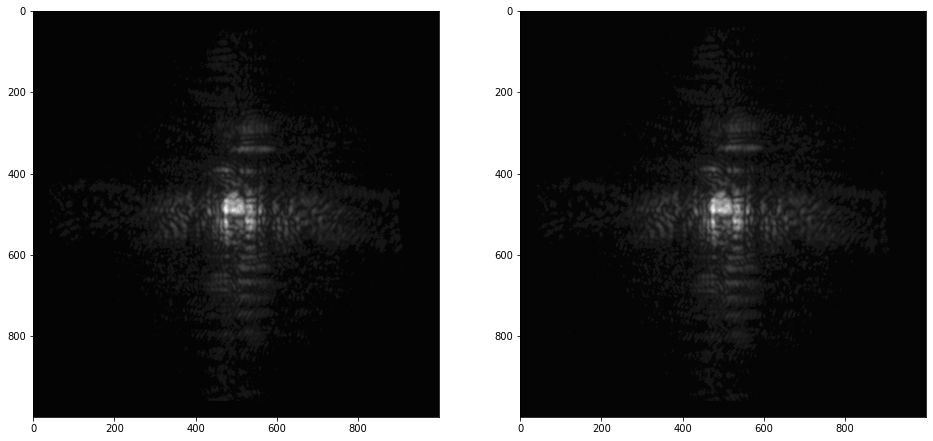

In [8]:
measurements=[]
z = []
k = 1
num_planes= 2
pad_to = [3220,3224,3224,3228,3232,3236,3240,3244,3244,3248,3252]
fig = plt.figure(figsize=(16, 8))
for offset in np.linspace(0, 50, num_planes):
    offset = int(offset)
    base = 104.5
    z.append((base*25.4+offset)*1e-3) ## propagation distance

    img = cv2.imread(f'datasets/{target_name}_{offset}mm.png', 0)/255.0
    img = np.sqrt(img) ## intensity to amplitude

    img = rescale(img, 2) ## projection
    img = pad_to_size(img, pad_to[offset//5])  ## add enough padding
    measurements.append(img)
    plt.subplot(1,num_planes,k)
    plt.imshow(crop_to_size(img,1000,0),cmap='gray')
    k+=1
plt.show()

initialization with PR result

In [14]:
target_est = np.load(f'datasets/{target_name}.npy')

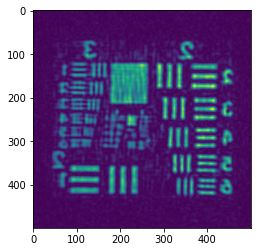

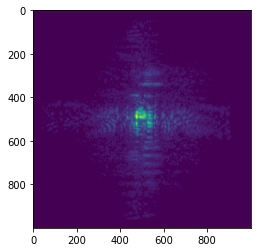

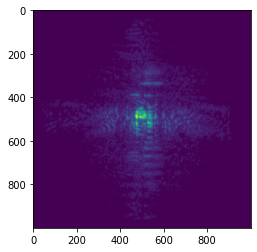

In [15]:
img = target_est#.to('cpu').numpy()

finite_supp = 800 if target_name == 'uoa' else 500

plt.imshow(np.abs(crop_to_size(img, finite_supp)))
plt.show()

scatter1 = pad_to_size(np.abs(measurements[0]), 4000)
scatter2 = pad_to_size(np.abs(measurements[1]), 4000)

cam_mags = np.concatenate((scatter1, scatter2))
plt.imshow(crop_to_size(cam_mags[:4000], 1000))
plt.show()
plt.imshow(crop_to_size(cam_mags[4000:], 1000))
plt.show()

In [16]:
from keras.models import load_model

denoiser = load_model("dncnn_50k.h5")

def denoi(x):
    x = np.abs(crop_to_size(x, finite_supp))
    shape = x.shape
    tensor_x = x.reshape(shape+(1,))
    return pad_to_size(denoiser.predict(tensor_x).reshape(shape), 1000)

In [17]:
# Optimization parameters
lamb = .1
proximal_iters=1
image_shape = img.shape
scatter_shape = cam_mags.shape
# defining the functions for the problem
def A(x):
    """
    linear operator A in f(Ax) + g(x)
    params
    -----
    x : np.ndarray, dtype = real
        Takes in the real image. 
    you may need to do reshaping here if oversampling
    """
    scatter1 = pad_to_size(MASD(x), 4000)
    scatter2 = pad_to_size(MASD2(x), 4000)
    return np.concatenate((scatter1, scatter2))
def At(x):
    """
    Adjoint/transpose of the linear operator A in f(Ax) + g(x)
    params
    -----
    x : np.ndarray, dtype = complex
        Takes in fourier magnitudes. 
    need to do reshaping here if oversampling
    """
    target1 = crop_to_size(RMASD(crop_to_size(x[:4000], 3220)), 1000)
    target2 = crop_to_size(RMASD2(crop_to_size(x[4000:], 3252)), 1000)
    return (target1 + target2)*0.5

def f(Z):
    out = .5 * la.norm((np.abs(Z) - cam_mags),ord='fro')**2 
    return out
def sub_grad_f(Z):
    """
    Subgradient function as in prDeep paper.
    params
    -----
    Z : 
    """
    out = Z-cam_mags*Z/(abs(Z)+1e-10)
    return out
def g(z):
    """
    This function is only used if evaluate_object = True, it is not necessary for the optimization
    """
    x = z.ravel()
    return .5*lamb*np.abs(x).T @ (np.abs(x)-denoi(x))


def proxg(Z, t):
    x = Z
    for i in range(proximal_iters):
        x = (1/(1+t*lamb))*(Z+t*lamb*denoi(x))
    return x



# Create the linear map object that holds A and At
Linear_map = LinearMap(A,At, Vshape=image_shape,Wshape=scatter_shape)

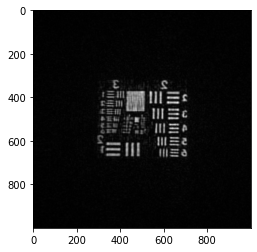

In [18]:
# Construct noisy initial guess
Y0 = img
plt.imshow(np.abs(Y0), cmap='gray')
plt.show()

Initializing FASTA...

Iteration #	Residual	Stepsize	Accel. param	Backtracks	Objective
[0     ]	2.001374e+01	9.679624e-01	1.000000e+00	     0	0.000000e+00
[1     ]	4.871194e+00	2.207734e+00	1.618034e+00	     0	0.000000e+00
[2     ]	3.544182e+00	2.605072e+00	2.193527e+00	     1	0.000000e+00
[3     ]	5.149829e+00	8.985349e-01	2.749791e+00	     1	0.000000e+00
[4     ]	1.807739e+00	3.063928e+00	3.294880e+00	     0	0.000000e+00
[5     ]	4.127175e+00	2.482364e+00	3.832601e+00	     0	0.000000e+00
Restarted acceleration.
[6     ]	9.778367e+00	1.079718e-01	1.000000e+00	     1	0.000000e+00
[7     ]	8.711056e+00	1.514451e-01	1.618034e+00	     1	0.000000e+00
[8     ]	7.068079e+00	5.939024e-01	2.193527e+00	     0	0.000000e+00
[9     ]	1.538852e+00	5.331427e-01	2.749791e+00	     0	0.000000e+00
[10    ]	1.231562e+00	1.161915e+00	3.294880e+00	     0	0.000000e+00
[11    ]	9.465869e-01	1.438557e+00	3.832601e+00	     1	0.000000e+00
[12    ]	9.077173e-01	1.145772e+00	4.365079e+00	     2	0.000000e+00
[13  

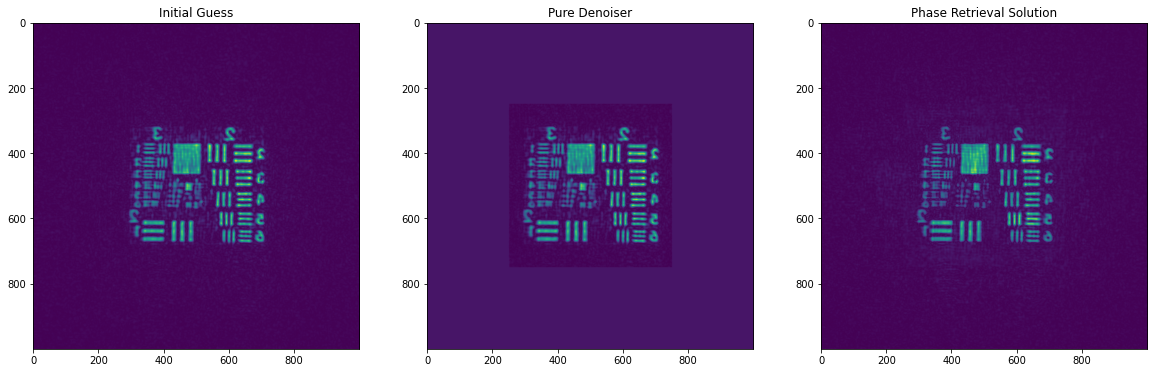

In [19]:
# Run up the solver
solver = fasta(A = Linear_map, f= f, gradf=sub_grad_f, g=g, proxg=proxg, x0=Y0,max_iters=50,
            accelerate=True, # Other options: plain, adapative
            evaluate_objective=False, #evaluate objective function at every step, slows it down
            verbose = True
           )

fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(20,6))
ax1.imshow(np.abs(Y0))
ax1.set_title('Initial Guess')
ax2.imshow(denoi(np.abs(Y0)))
ax2.set_title('Pure Denoiser')
ax3.imshow(np.abs(solver.solution))
ax3.set_title('Phase Retrieval Solution')
plt.show()

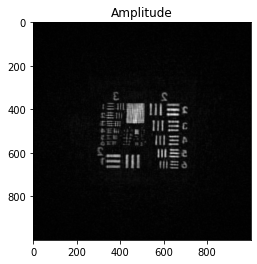

Amplitude shape: (1000, 1000), dtype: float64
Amplitude stat: max: 2.4181883692723494, min: 4.060144805734975e-05, mean: 0.0891284319944451, std: 0.21648537712327637


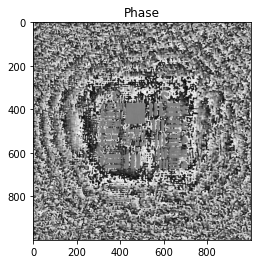

Phase shape: (1000, 1000), dtype: float64
Phase stat: max: 3.1415917922920653, min: -3.1415847642121686, mean: -0.008308715610433169, std: 1.8634779106513037


In [20]:
show_stats(solver.solution)

In [21]:
cv2.imwrite(f'results/{target_name}_prpnp_result.png', np.abs(solver.solution)/np.abs(solver.solution).max()*255.0)
np.save(f'results/{target_name}_prpnp_result.npy', solver.solution)